In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, ZeroPadding2D, BatchNormalization, Input, Activation, Add, GlobalAveragePooling1D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import os

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version:", sys.version)
print("Tensorflow Version", tf.__version__)

Python Version: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version 2.16.1


In [3]:
# **Data Loading and Preprocessing**

# Use a consistent file path format (e.g., os.path.join)
furniture_df = pd.read_csv(os.path.join("..", "furniture_data.csv"))
furniture_sliding_df = pd.read_csv(os.path.join("..", "furniture_sliding_data.csv"))
full_furniture_df = pd.concat([furniture_df, furniture_sliding_df], axis=0)

In [4]:
full_furniture_df['Furniture_Category_Type'] = full_furniture_df['Furniture_Category'] + '-' + full_furniture_df['Furniture_Type']

full_furniture_df

,Furniture_Category,Furniture_Type,Image_Path,Furniture_Category_Type
0,beds,Asian,../Furniture_Data\beds\Asian\19726asian-daybed...,beds-Asian
1,beds,Asian,../Furniture_Data\beds\Asian\20027asian-canopy...,beds-Asian
2,beds,Asian,../Furniture_Data\beds\Asian\20109asian-panel-...,beds-Asian
3,beds,Asian,../Furniture_Data\beds\Asian\20508asian-platfo...,beds-Asian
4,beds,Asian,../Furniture_Data\beds\Asian\20750asian-comfor...,beds-Asian
...,...,...,...,...
328609,tables,Victorian,../CrawledData\tables\Victorian\9victorian-sid...,tables-Victorian
328610,tables,Victorian,../CrawledData\tables\Victorian\9victorian-sid...,tables-Victorian
328611,tables,Victorian,../CrawledData\tables\Victorian\9victorian-sid...,tables-Victorian
328612,tables,Victorian,../CrawledData\tables\Victorian\9victorian-sid...,tables-Victorian


In [5]:
categorical_folders = full_furniture_df["Furniture_Category_Type"].unique()
print(categorical_folders)

num_classes = full_furniture_df["Furniture_Category_Type"].nunique()
print("Number of classes:", num_classes)

['beds-Asian' 'beds-Beach' 'beds-Contemporary' 'beds-Craftsman'
 'beds-Eclectic' 'beds-Farmhouse' 'beds-Industrial' 'beds-Mediterranean'
 'beds-Midcentury' 'beds-Modern' 'beds-Rustic' 'beds-Scandinavian'
 'beds-Southwestern' 'beds-Traditional' 'beds-Transitional'
 'beds-Tropical' 'beds-Victorian' 'chairs-Asian' 'chairs-Beach'
 'chairs-Contemporary' 'chairs-Craftsman' 'chairs-Eclectic'
 'chairs-Farmhouse' 'chairs-Industrial' 'chairs-Mediterranean'
 'chairs-Midcentury' 'chairs-Modern' 'chairs-Rustic' 'chairs-Scandinavian'
 'chairs-Southwestern' 'chairs-Traditional' 'chairs-Transitional'
 'chairs-Tropical' 'chairs-Victorian' 'dressers-Asian' 'dressers-Beach'
 'dressers-Contemporary' 'dressers-Craftsman' 'dressers-Eclectic'
 'dressers-Farmhouse' 'dressers-Industrial' 'dressers-Mediterranean'
 'dressers-Midcentury' 'dressers-Modern' 'dressers-Rustic'
 'dressers-Scandinavian' 'dressers-Southwestern' 'dressers-Traditional'
 'dressers-Transitional' 'dressers-Tropical' 'dressers-Victorian'
 'la

In [6]:
full_furniture_count = full_furniture_df['Furniture_Category_Type'].value_counts()

In [7]:
dev, test = train_test_split(full_furniture_df,train_size=0.85, shuffle=True, random_state=333)
print(dev.shape, test.shape)

(355893, 4) (62805, 4)


In [8]:
# **Constants and Hyperparameters**

BATCH_SIZE = 32
IMG_WIDTH  = 227
IMG_HEIGHT = 227

In [9]:
# Data Augmentation and Normalization

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=30,              
    width_shift_range=0.1,        
    height_shift_range=0.1,        
    shear_range=0.2,
    zoom_range=0.2,              
    horizontal_flip=True,
    brightness_range=[0.5, 1.3],  
    fill_mode='nearest',
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1/255.0) 

In [10]:
train_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category_Type',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category_Type',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Image_Path',
    y_col='Furniture_Category_Type',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 64980 validated image filenames belonging to 102 classes.
Found 11466 validated image filenames belonging to 102 classes.
Found 13636 validated image filenames.


In [11]:
print(train_ds.class_indices)

{'beds-Asian': 0, 'beds-Beach': 1, 'beds-Contemporary': 2, 'beds-Craftsman': 3, 'beds-Eclectic': 4, 'beds-Farmhouse': 5, 'beds-Industrial': 6, 'beds-Mediterranean': 7, 'beds-Midcentury': 8, 'beds-Modern': 9, 'beds-Rustic': 10, 'beds-Scandinavian': 11, 'beds-Southwestern': 12, 'beds-Traditional': 13, 'beds-Transitional': 14, 'beds-Tropical': 15, 'beds-Victorian': 16, 'chairs-Asian': 17, 'chairs-Beach': 18, 'chairs-Contemporary': 19, 'chairs-Craftsman': 20, 'chairs-Eclectic': 21, 'chairs-Farmhouse': 22, 'chairs-Industrial': 23, 'chairs-Mediterranean': 24, 'chairs-Midcentury': 25, 'chairs-Modern': 26, 'chairs-Rustic': 27, 'chairs-Scandinavian': 28, 'chairs-Southwestern': 29, 'chairs-Traditional': 30, 'chairs-Transitional': 31, 'chairs-Tropical': 32, 'chairs-Victorian': 33, 'dressers-Asian': 34, 'dressers-Beach': 35, 'dressers-Contemporary': 36, 'dressers-Craftsman': 37, 'dressers-Eclectic': 38, 'dressers-Farmhouse': 39, 'dressers-Industrial': 40, 'dressers-Mediterranean': 41, 'dressers-Mi

(32, 227, 227, 3)
(32, 102)
Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


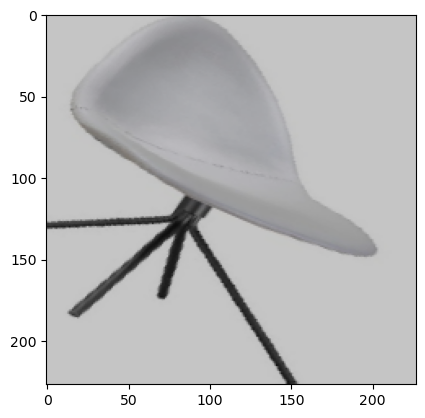

Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


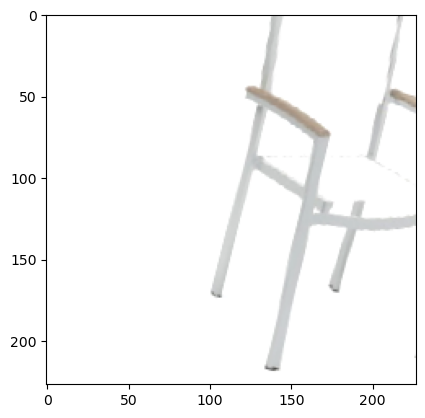

Label:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


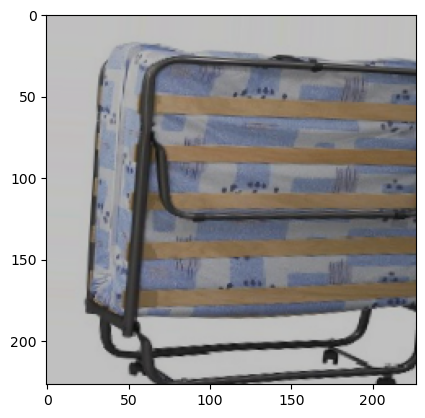

In [12]:
# **Visualize Augmented Data**

batchX, batchY = train_ds.__next__()
print(batchX.shape)
print(batchY.shape)

for i in range(3):
    img = batchX[i]
    label = batchY[i]
    print('Label: ', label)
    plt.imshow(img)
    plt.show()

In [13]:
model = Sequential()

# Layer 1
model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# Layers 3-5
model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

model.add(Flatten())

# Smaller Dense Layers
model.add(Dense(2048, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu')) 
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    18,876,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,028,966 (103.11 MB)

 Trainable params: 27,028,966 (103.11 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
optimization = tf.keras.optimizers.SGD(learning_rate=0.001)


model.compile(optimizer=optimization, 
              loss=BinaryCrossentropy(from_logits=True), 
              metrics=[BinaryAccuracy()])


early_stopping_callback = EarlyStopping(
    monitor='val_binary_accuracy',
    patience = 15,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.0001,
)

In [15]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs= 5,
    batch_size=BATCH_SIZE, 
    callbacks=[early_stopping_callback]
)

Epoch 1/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1030s 506ms/step - binary_accuracy: 0.9899 - loss: 0.5604 - val_binary_accuracy: 0.9902 - val_loss: 0.0596
Epoch 2/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1032s 507ms/step - binary_accuracy: 0.9885 - loss: 0.0844 - val_binary_accuracy: 0.9902 - val_loss: 0.0570
Epoch 3/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1012s 497ms/step - binary_accuracy: 0.9890 - loss: 0.0735 - val_binary_accuracy: 0.9902 - val_loss: 0.0560
Epoch 4/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1020s 501ms/step - binary_accuracy: 0.9892 - loss: 0.0693 - val_binary_accuracy: 0.9902 - val_loss: 0.0551
Epoch 5/5
2031/2031 ━━━━━━━━━━━━━━━━━━━━ 1010s 496ms/step - binary_accuracy: 0.9894 - loss: 0.0672 - val_binary_accuracy: 0.9902 - val_loss: 0.0546
Restoring model weights from the end of the best epoch: 1.


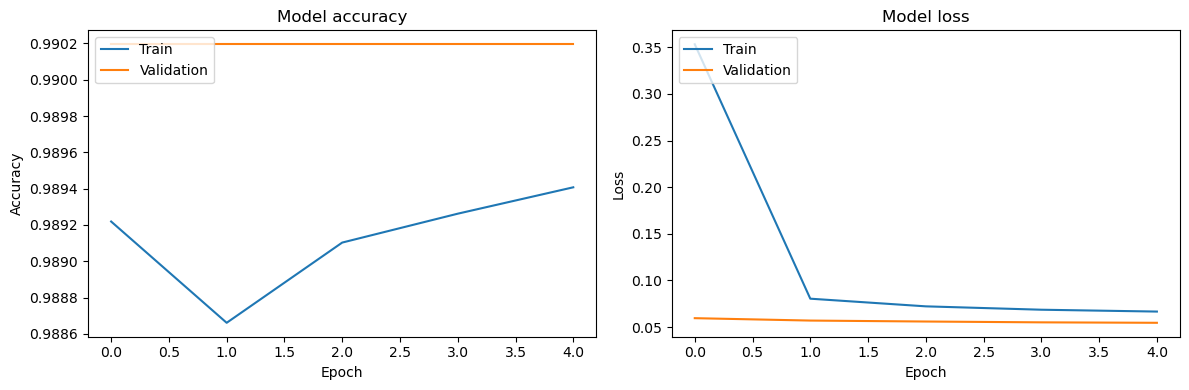

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [24]:
model.save('../TrainingModels/AlexNet.keras')